### Training with ImageDataGenerator

### Download the data and have a look at it

In [1]:
# Download horse-or-human.zip
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2023-05-15 07:19:36--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 74.125.141.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   157MB/s    in 0.9s    

2023-05-15 07:19:37 (157 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [2]:
# Unzip the downloaded file
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `./horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

Now, we'll label the images as `horses` or `humans` using `ImageDataGenerator` API & it will label images according to the directory names and structure.

In [3]:
# Define the directories

import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

Now see what the filenames look like in the `horses` and `humans` training directories:

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse05-4.png', 'horse23-5.png', 'horse08-9.png', 'horse16-4.png', 'horse44-8.png', 'horse18-5.png', 'horse11-3.png', 'horse30-0.png', 'horse44-9.png', 'horse44-0.png']
['human04-10.png', 'human10-16.png', 'human07-01.png', 'human01-16.png', 'human11-16.png', 'human11-04.png', 'human02-04.png', 'human12-03.png', 'human05-03.png', 'human12-25.png']


In [5]:
# Check total training images

print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now take a look at a few pictures to get a better sense of what they look like.

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Display a batch of 8 horse and 8 human pictures

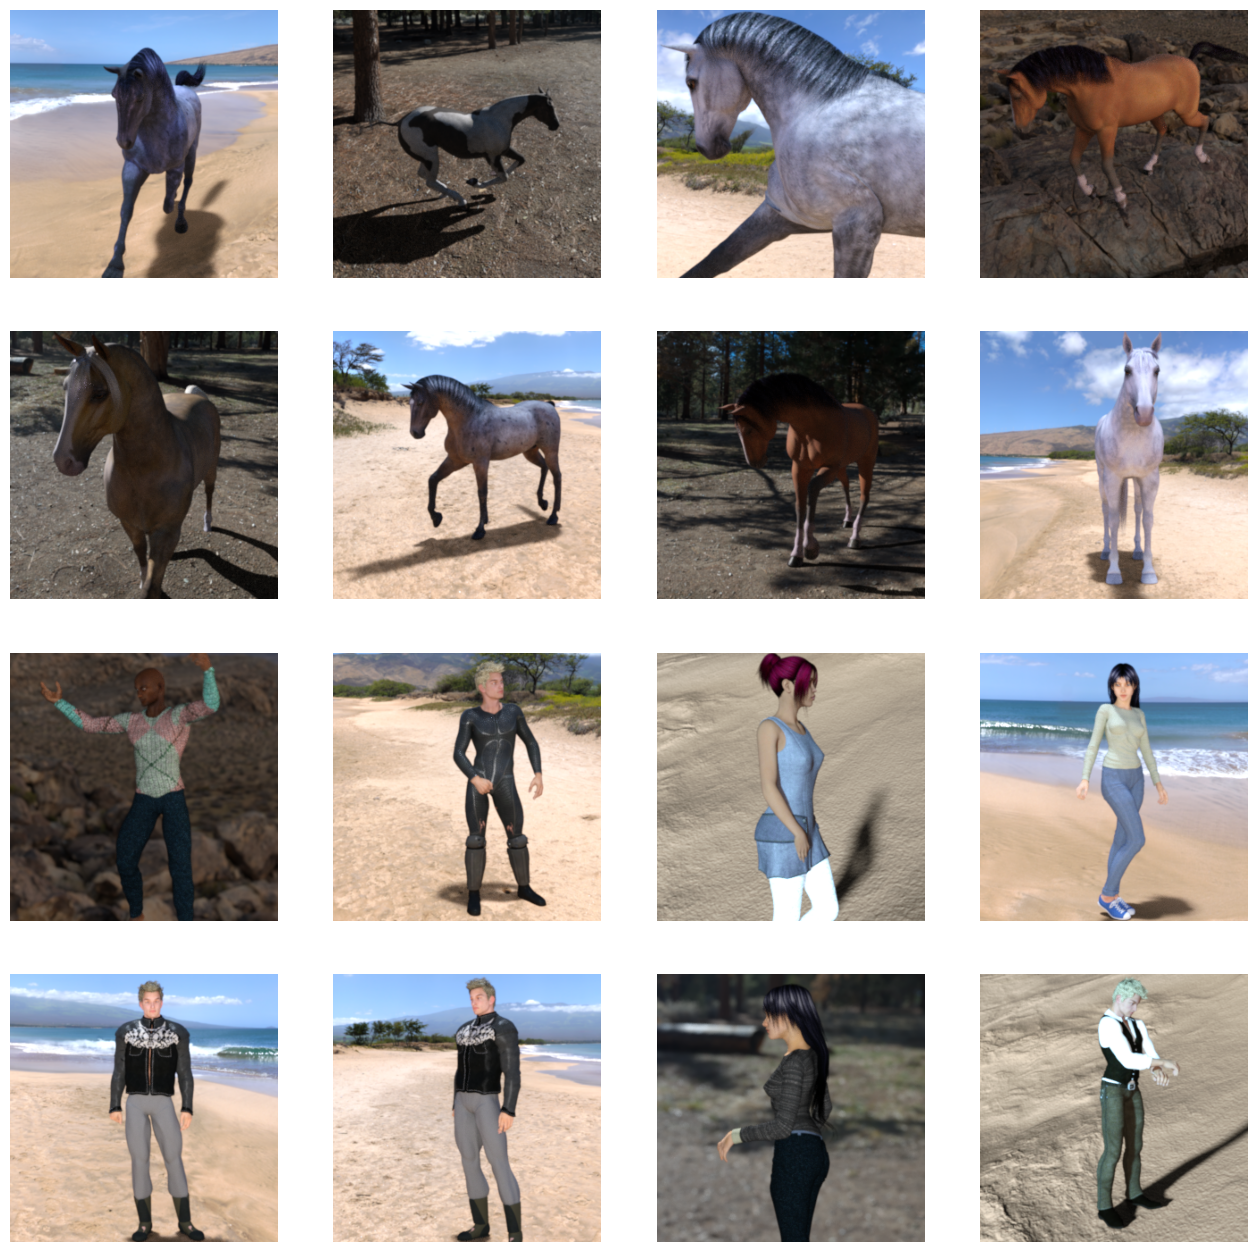

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Building small model

In [8]:
import tensorflow as tf

In [9]:
# Create the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [11]:
# Complie the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model. 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configure the ImageDataGenerator to normalize each images
train_datagen = ImageDataGenerator(rescale = 1/255)

# Load the training data in batches of 128 using train_datagen
train_generator = train_datagen.flow_from_directory(
    './horse-or-human/', # This is the source directory for training images
    target_size = (300, 300), # All images will be resized to 300x300
    batch_size = 128,
    class_mode = 'binary'
)


Found 1027 images belonging to 2 classes.


### Training

In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 112s 13s/step - loss: 0.8687 - accuracy: 0.5795
Epoch 2/15
8/8 [==============================] - 107s 15s/step - loss: 0.6874 - accuracy: 0.6251
Epoch 3/15
8/8 [==============================] - 118s 14s/step - loss: 0.6571 - accuracy: 0.6229
Epoch 4/15
8/8 [==============================] - 110s 16s/step - loss: 0.6433 - accuracy: 0.6407
Epoch 5/15
8/8 [==============================] - 109s 13s/step - loss: 0.5376 - accuracy: 0.7297
Epoch 6/15
8/8 [==============================] - 109s 13s/step - loss: 1.2184 - accuracy: 0.7453
Epoch 7/15
8/8 [==============================] - 108s 13s/step - loss: 0.2889 - accuracy: 0.9155
Epoch 8/15
8/8 [==============================] - 117s 17s/step - loss: 0.2586 - accuracy: 0.8832
Epoch 9/15
8/8 [==============================] - 108s 13s/step - loss: 0.1198 - accuracy: 0.9600
Epoch 10/15
8/8 [==============================] - 108s 13s/step - loss: 0.1137 - accuracy: 0.9577
Epoch 11/15
8/8 [==

### Model Prediction

In [14]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving pexels-helena-lopes-1996332.jpg to pexels-helena-lopes-1996332.jpg
1/1 [==============================] - 0s 198ms/step
[0.02774535]
pexels-helena-lopes-1996332.jpg is a horse


### Visualizing intermediate responses

1/1 [==============================] - 0s 355ms/step


<ipython-input-15-3501e75cf878>:45: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


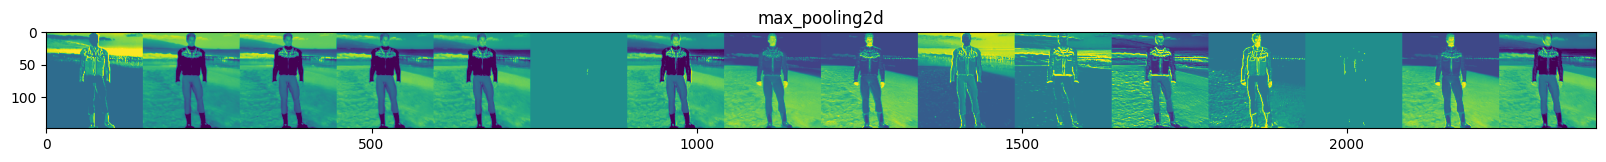

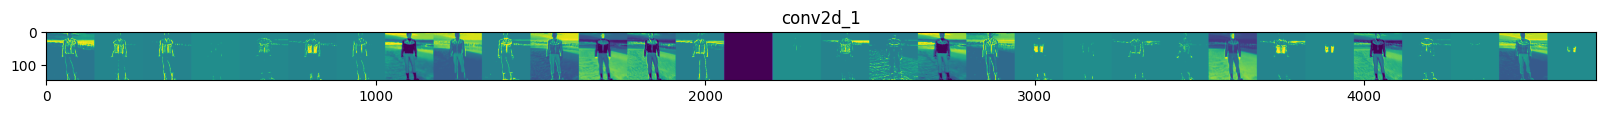

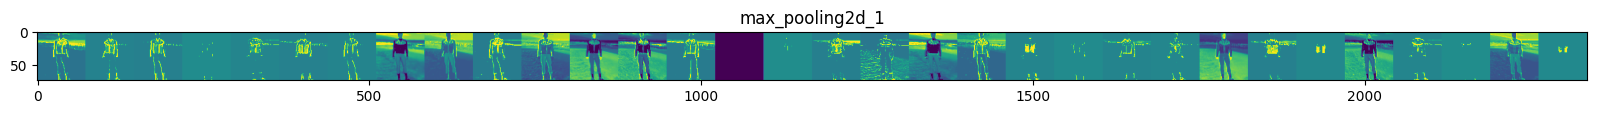

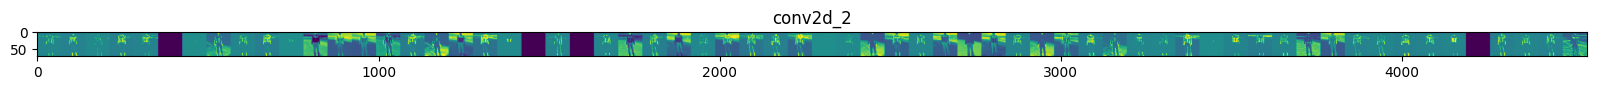

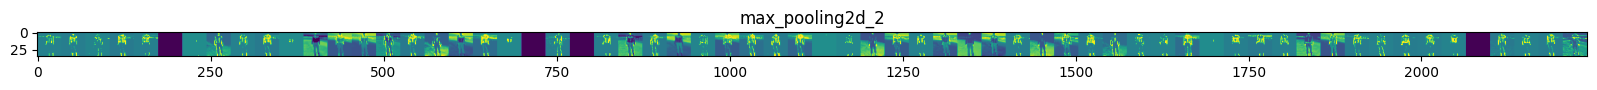

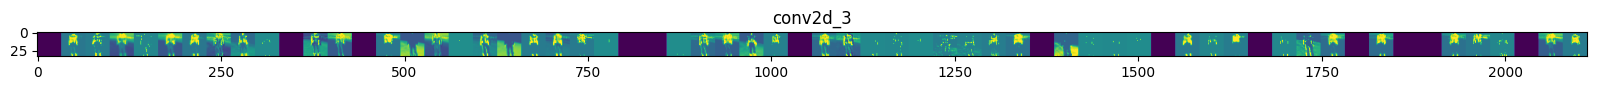

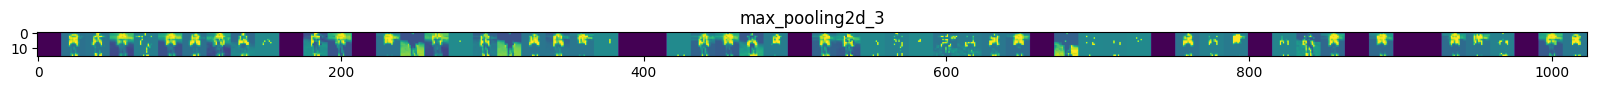

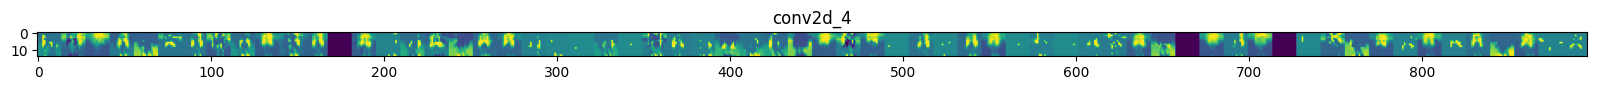

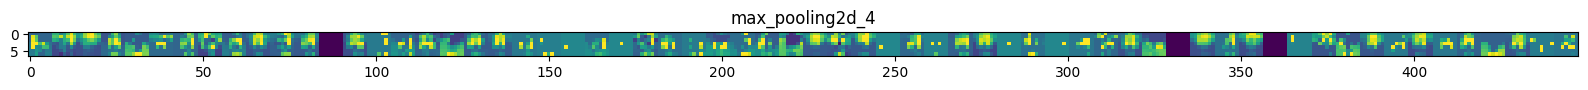

In [15]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')